Unfortunately, the dataset we use for the main analysis is not suitable for this type of analysis, so we will use additional data from the Quandl library. The most suitable data for us were the following 
The Consumer Price Index (CPI) measures the monthly change in prices paid by American consumers. 

## Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight')

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'hqLZ1xtKbE-AoehCmywX'

In [3]:
df = quandl.get('FRED/CPIAUCSL')

In [4]:
df.head()

,Value
Date,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


In [5]:
df.shape

(901, 1)

In [6]:
type(df)

pandas.core.frame.DataFrame

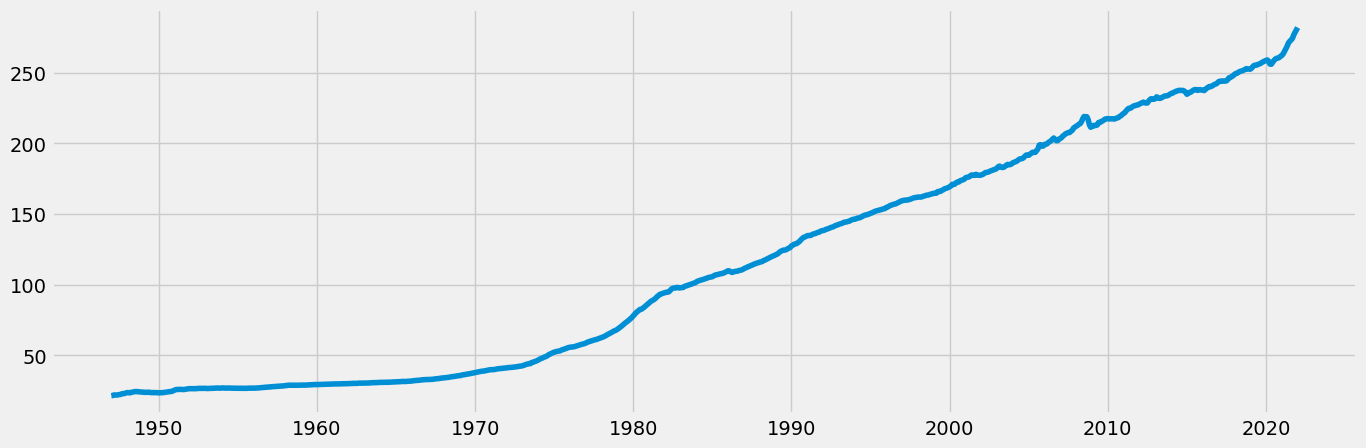

In [7]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(df)

## Subsetting, wrangling, and cleaning time-series data

In [8]:
# Reset index so that you can use the "Date" column as a filter

df_2 = df.reset_index()

In [9]:
df_2.head()

,Date,Value
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


In [10]:
df_sub = df_2.loc[(df_2['Date'] >= '1990-01-01') & (df_2['Date'] < '2020-01-01')]

In [11]:
df_sub.shape

(360, 2)

In [12]:
df_sub.head()

,Date,Value
516,1990-01-01,127.5
517,1990-02-01,128.0
518,1990-03-01,128.6
519,1990-04-01,128.9
520,1990-05-01,129.1


In [13]:
# Set the "Date" column as the index

from datetime import datetime

df_sub['datetime'] = pd.to_datetime(df_sub['Date']) 
df_sub = df_sub.set_index('datetime')
df_sub.drop(['Date'], axis=1, inplace=True) 
df_sub.head()

,Value
datetime,
1990-01-01,127.5
1990-02-01,128.0
1990-03-01,128.6
1990-04-01,128.9
1990-05-01,129.1


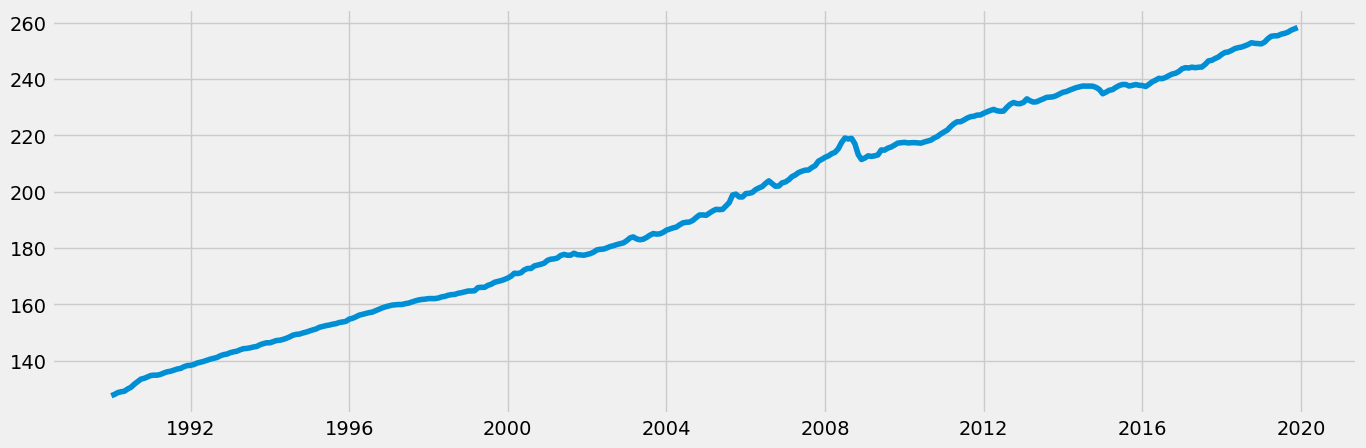

In [14]:
# Plot the new data set
plt.figure(figsize=(15,5), dpi=100) 
    

plt.plot(df_sub)

In [15]:
df_sub.isnull().sum() 

Value    0
dtype: int64

In [16]:
dups = df_sub.duplicated()
dups.sum()

16

## Time-series analysis: decomposition

In [17]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_sub,model='additive')

In [18]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

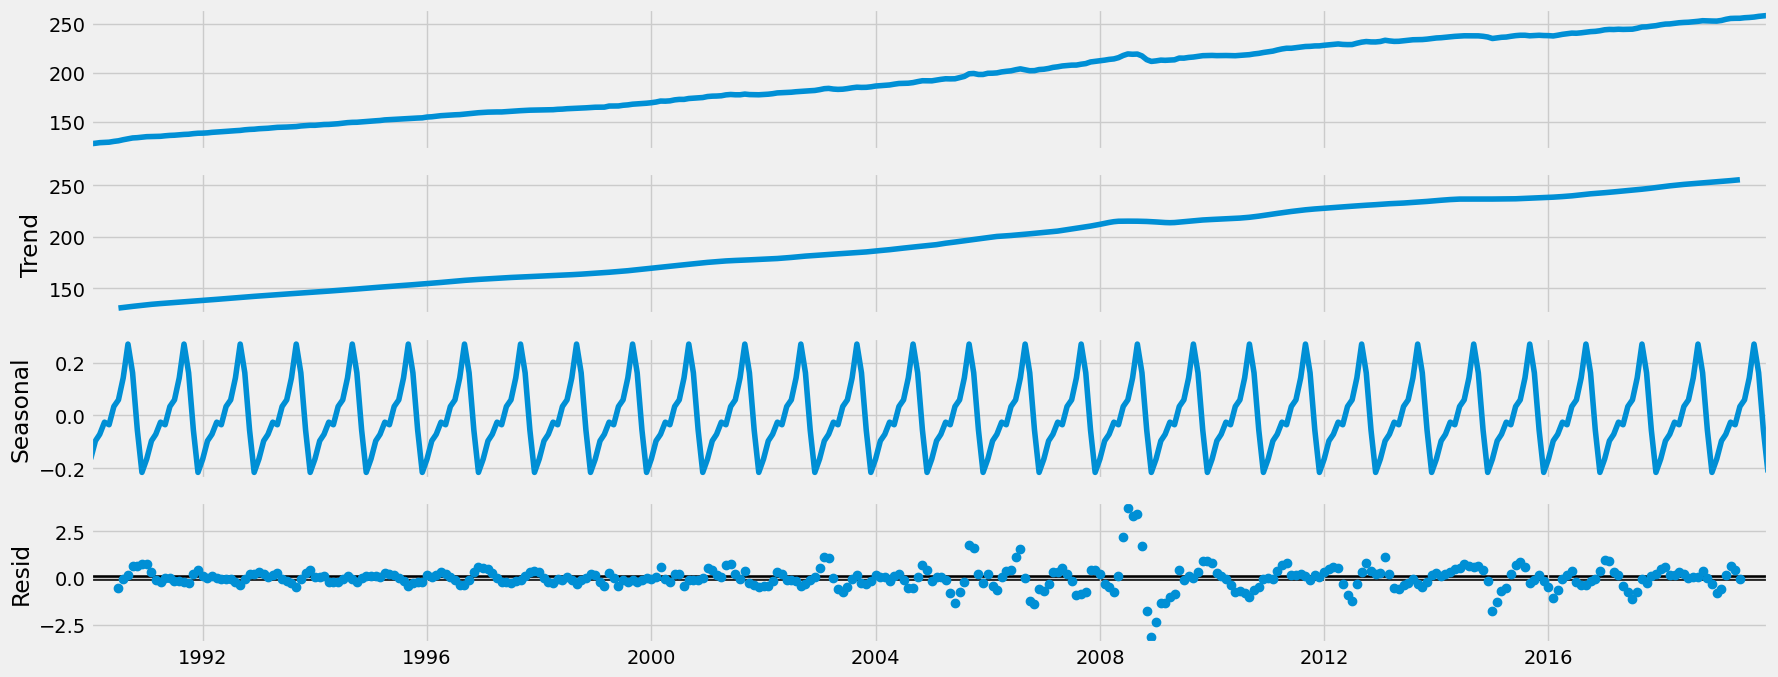

In [19]:
# Plot the separate components

decomposition.plot()
plt.show()

On this graph we can see that over the last 30 years there has been an upward trend, only in 2008 we can see that there was a decrease in the CPI, but this was most likely due to the economic crisis.

## Testing for stationarity

In [20]:
from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries):
    
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.026593
p-value                          0.960677
Number of Lags Used             12.000000
Number of Observations Used    347.000000
Critical Value (1%)             -3.449337
Critical Value (5%)             -2.869906
Critical Value (10%)            -2.571227
dtype: float64


The Dickey-Fuller test we applied showed that this time series is not stationary.

The Critical Value (10%) -2.571227, which is higher than the Test Statistic of 0.026593.
Also, the p-value of 0.960677 indicates that the test result is not significant.

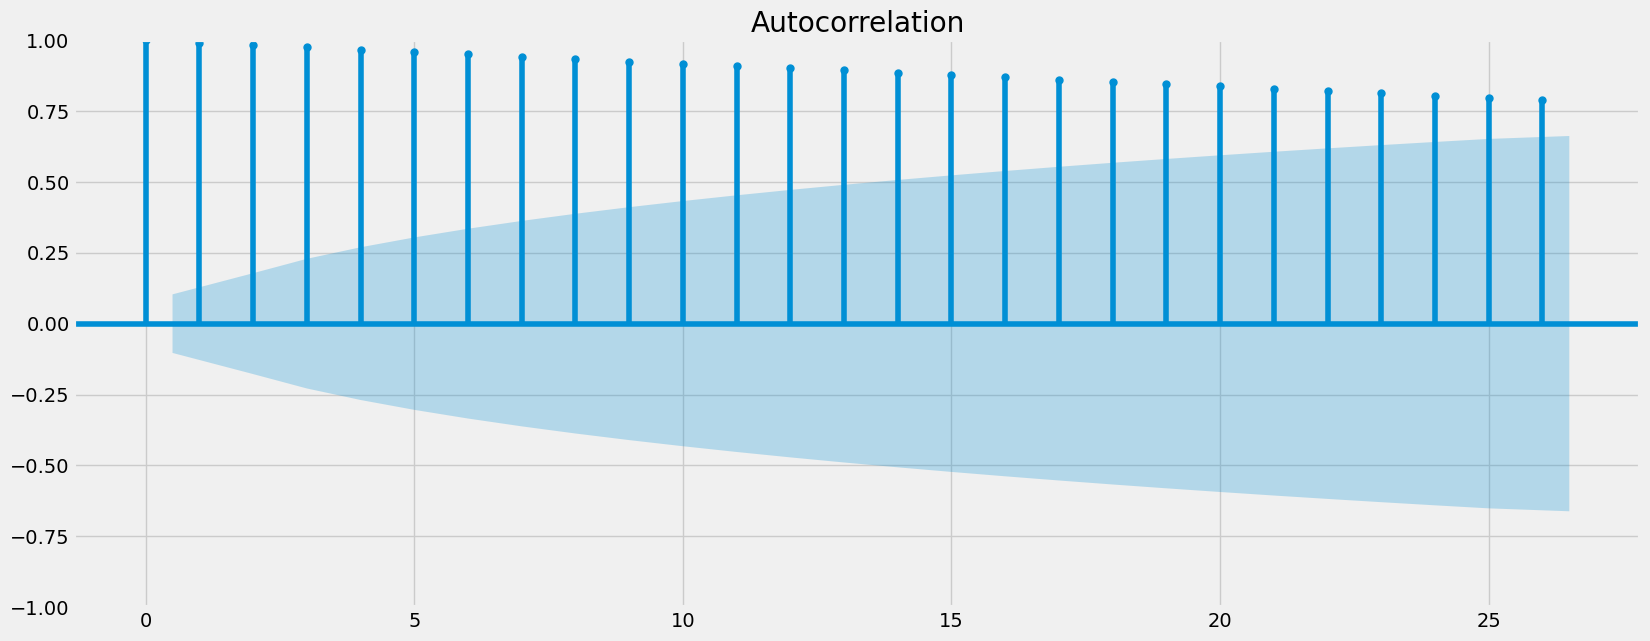

In [21]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(df_sub)
plt.show()

The vertical lines show the lags in the series, and the blue area is the confidence interval. When the lines fall outside the blue boundary of the confidence interval, it means that the lags are significantly correlated. We have many lags outside this interval, and we can conclude that the data is non-stationary.

##  Stationarizing

In [22]:
df_diff = df_sub - df_sub.shift(1)

In [23]:
df_diff.dropna(inplace = True)

In [24]:
df_diff.head()

,Value
datetime,
1990-02-01,0.5
1990-03-01,0.6
1990-04-01,0.3
1990-05-01,0.2
1990-06-01,0.8


In [25]:
df_diff.columns

Index(['Value'], dtype='object')

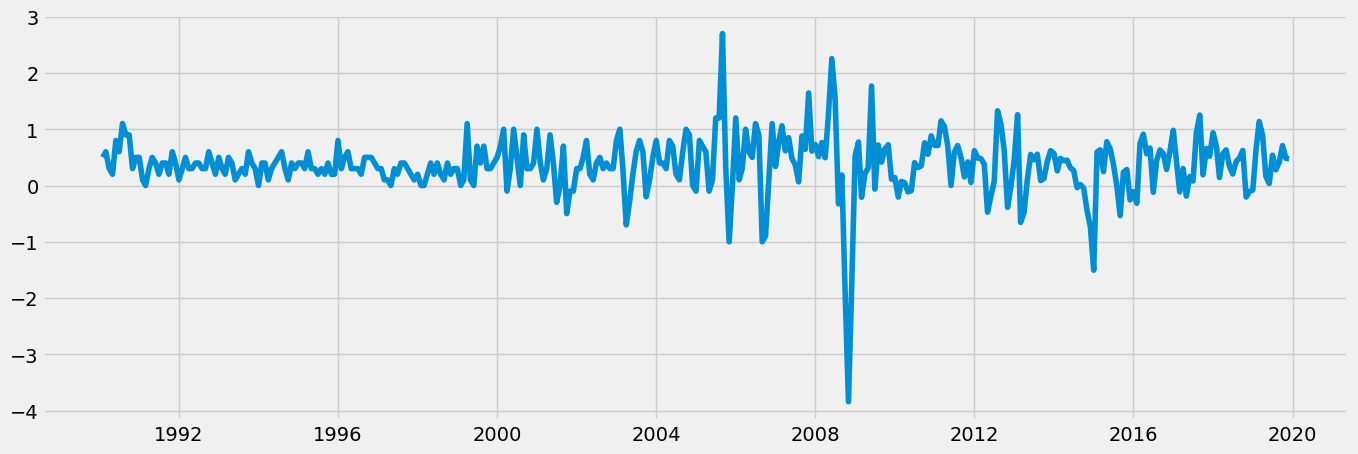

In [26]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff)

In [27]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.811986e+00
p-value                        2.104897e-09
Number of Lags Used            1.100000e+01
Number of Observations Used    3.470000e+02
Critical Value (1%)           -3.449337e+00
Critical Value (5%)           -2.869906e+00
Critical Value (10%)          -2.571227e+00
dtype: float64


After performing the stationarization of the CPI time series using the differentiation method, we can see that the test statistic has become less than the critical value at both the five- and ten-percent significance levels. This shows that we can reject the null hypothesis and, as a result, consider the CPI data series stationary.

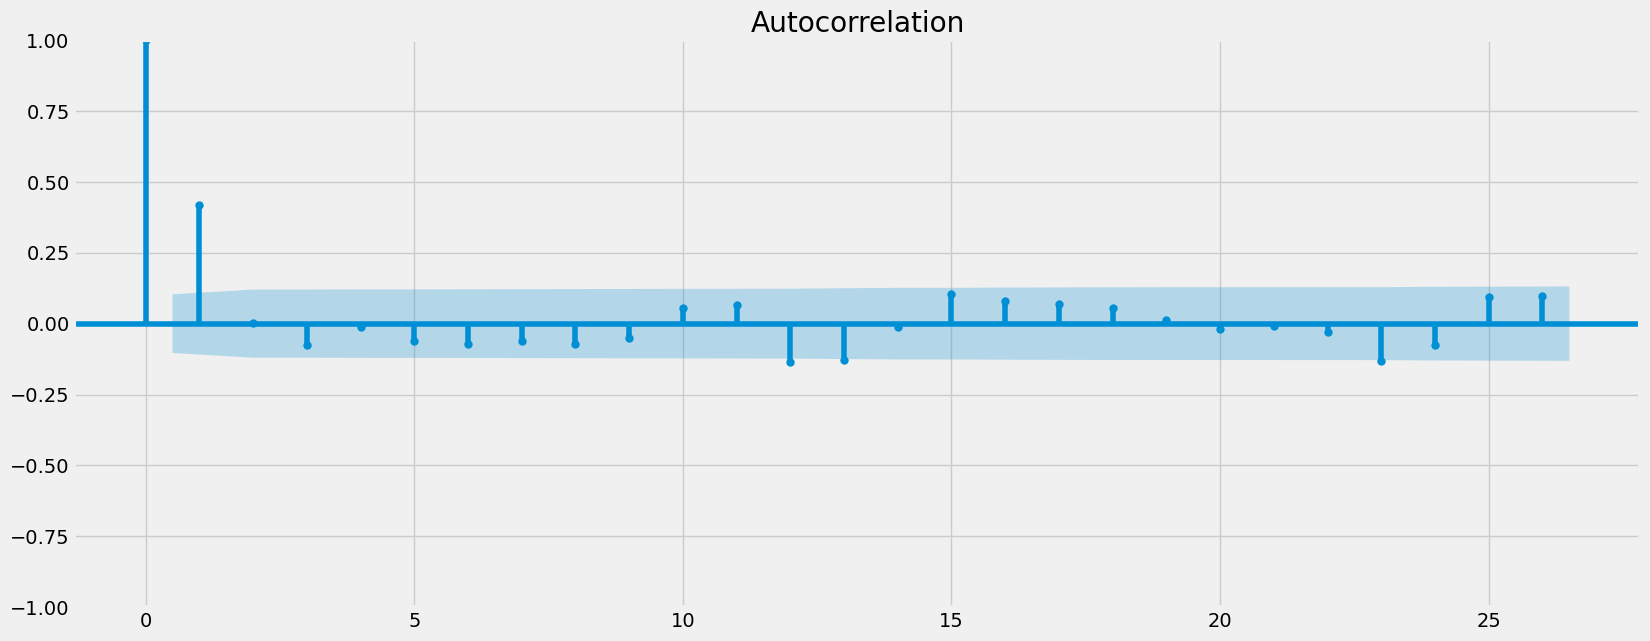

In [28]:
plot_acf(df_diff)
plt.show()

The autocorrelation plot is much improved, but it is still not perfect. This means that although the Dickey-Fuller test shows that the data is stationary, this stationarity is weak. However, since the number of autocorrelated terms is less than 10, we do not need to re-estimate the autocorrelation.